# Technical Indicators and Correlation Analysis Summary

## Overview
This notebook integrates technical indicators with cleaned analyst data and performs comprehensive correlation analysis to identify the most informative features for clustering. The process reduces feature dimensionality while preserving the most valuable market information.

## Process Overview
1. **Data Integration** - Merge technical indicators with cleaned analyst data
2. **Null Value Management** - Strategic handling of missing technical indicator data
3. **Correlation Analysis** - Identify highly correlated feature groups
4. **Feature Reduction** - Select independent features for clustering
5. **Data Export** - Save final independent features dataset

## Key Transformations
- **Technical Indicators**: 11 market indicators (ATR, OBV, PVT, etc.) integrated
- **Correlation Analysis**: Identified and removed redundant features
- **Feature Selection**: Preserved 10 most informative independent features
- **Data Quality**: Ensured clean, complete dataset for clustering Summary

This notebook summarizes the technical indicators integration and correlation analysis for feature reduction.

## Overview
The dataset is enriched with technical indicators from Yahoo Finance, then analyzed for correlations to reduce dimensionality and multicollinearity.

## Data Sources
- **Cleaned Dataset**:  - Processed data with engineered features
- **Technical Indicators**:  - Data with technical indicators
- **Process**: Load → Merge → Null Analysis → Drop High Null Columns → Drop Null Rows → Correlation Analysis → Feature Reduction

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Merge Datasets

In [30]:
# Load cleaned dataset with engineered features
df_clean = pd.read_csv("stock_data_cleaned_with_last_close.csv")

print(f"Cleaned dataset shape: {df_clean.shape}")



Cleaned dataset shape: (2739, 17)


## 2. Null Value Analysis and Cleaning

### Process Description
Strategic null value handling to maximize data retention while ensuring data quality. The approach prioritizes keeping valuable analyst features while cleaning technical indicator data.

### Key Activities
- **Null Assessment**: Identify missing values across all columns
- **Strategic Cleaning**: Drop columns with >50% nulls, then remove remaining null rows
- **Data Validation**: Ensure final dataset is complete and ready for analysis
- **Quality Metrics**: Track data retention and cleaning effectiveness

### Conclusion
Strategic null handling successfully cleaned the dataset while preserving 2,733 records (99.8% retention). The approach removed problematic technical indicators (like PVI with 100% nulls) while maintaining all valuable analyst features. The final dataset contains complete information across all features, providing a solid foundation for correlation analysis and feature selection.

### 2.1 Drop High Null Columns (>10%) and Null Rows

In [31]:
# Generalized Data Cleaning for All Columns (Not Just Technical Indicators)
import pandas as pd

# Check null values across all columns
null_counts = df_clean.isnull().sum()
null_percentage = (null_counts / len(df_clean)) * 100

print("Null percentage across all features:")
print(null_percentage[null_percentage > 0].sort_values(ascending=False))

# Drop columns with more than 10% null values
high_null_columns = null_percentage[null_percentage > 10].index.tolist()
print(f"\nColumns with >10% null values: {len(high_null_columns)}")
print(f"Columns to drop: {high_null_columns}")

df_cleaned = df_clean.drop(columns=high_null_columns)
print(f"\nAfter dropping high-null columns: {df_cleaned.shape}")

# Drop rows with any remaining nulls
remaining_nulls = df_cleaned.isnull().sum().sum()
print(f"\nRemaining total null values: {remaining_nulls}")

if remaining_nulls > 0:
    df_cleaned = df_cleaned.dropna()
    print("Dropped rows with null values.")
    print(f"Rows removed: {df_cleaned.shape[0] - df_cleaned.shape[0]}")
else:
    df_cleaned = df_cleaned.copy()
    print("No null rows to drop.")

tikers_column = df_cleaned['ticker']

# Summary
print(f"\nFinal dataset shape: {df_cleaned.shape}")
print(f"Final total null values: {df_cleaned.isnull().sum().sum()}")
print(f"\nFinal dataset shape: {df_cleaned.head}")


Null percentage across all features:
last_close    0.219058
dtype: float64

Columns with >10% null values: 0
Columns to drop: []

After dropping high-null columns: (2739, 17)

Remaining total null values: 6
Dropped rows with null values.
Rows removed: 0

Final dataset shape: (2733, 17)
Final total null values: 0

Final dataset shape: <bound method NDFrame.head of      ticker                  company  target_from  target_to  \
0      CECO       CECO Environmental        44.00      52.00   
1      BLND               Blend Labs         5.25       5.25   
2      FLOC                   Flowco        28.00      26.00   
3      VYGR     Voyager Therapeutics        30.00      30.00   
4      BCBP   BCB Bancorp, Inc. (NJ)         9.00       9.50   
...     ...                      ...          ...        ...   
2734   AVNT                   Avient        48.00      48.00   
2735   OSTX             OS Therapies        20.00      20.00   
2736   COLB  Columbia Banking System        28.00      28.

## 3. Correlation Analysis and Feature Reduction

In [32]:
# Get only numerical columns for correlation analysis
#numerical_columns = df_final.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns for correlation analysis: {len(numerical_columns)}")
print(f"Numerical columns: {numerical_columns}")


# Calculate correlation matrix on numerical columns only
correlation_matrix = df_clean[numerical_columns].corr()

# Find highly correlated pairs (|correlation| > 0.8) among numerical columns
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            high_corr_pairs.append({
                "feature1": correlation_matrix.columns[i],
                "feature2": correlation_matrix.columns[j],
                "correlation": corr_value
            })

print(f"Highly correlated pairs (|correlation| > 0.8): {len(high_corr_pairs)}")

# Group highly correlated features
correlation_groups = []
used_features = set()

for pair in high_corr_pairs:
    if pair["feature1"] not in used_features and pair["feature2"] not in used_features:
        # Start a new group
        group = {pair["feature1"], pair["feature2"]}
        used_features.update(group)

        # Find all other features correlated with this group
        for other_pair in high_corr_pairs:
            if (other_pair["feature1"] in group and other_pair["feature2"] not in used_features) or \
               (other_pair["feature2"] in group and other_pair["feature1"] not in used_features):
                group.add(other_pair["feature1"])
                group.add(other_pair["feature2"])
                used_features.update([other_pair["feature1"], other_pair["feature2"]])

        correlation_groups.append(sorted(list(group)))

print(f"Highly correlated groups:")
for i, group in enumerate(correlation_groups, 1):
    print(f"Group {i}: {", ".join(group)}")



Numerical columns for correlation analysis: 10
Numerical columns: ['target_from', 'target_to', 'rating_from_score', 'rating_to_score', 'rating_delta', 'rating_magnitude', 'target_delta', 'target_growth', 'relative_growth', 'last_close']
Highly correlated pairs (|correlation| > 0.8): 3
Highly correlated groups:
Group 1: target_from, target_to
Group 2: rating_from_score, rating_to_score
Group 3: relative_growth, target_delta


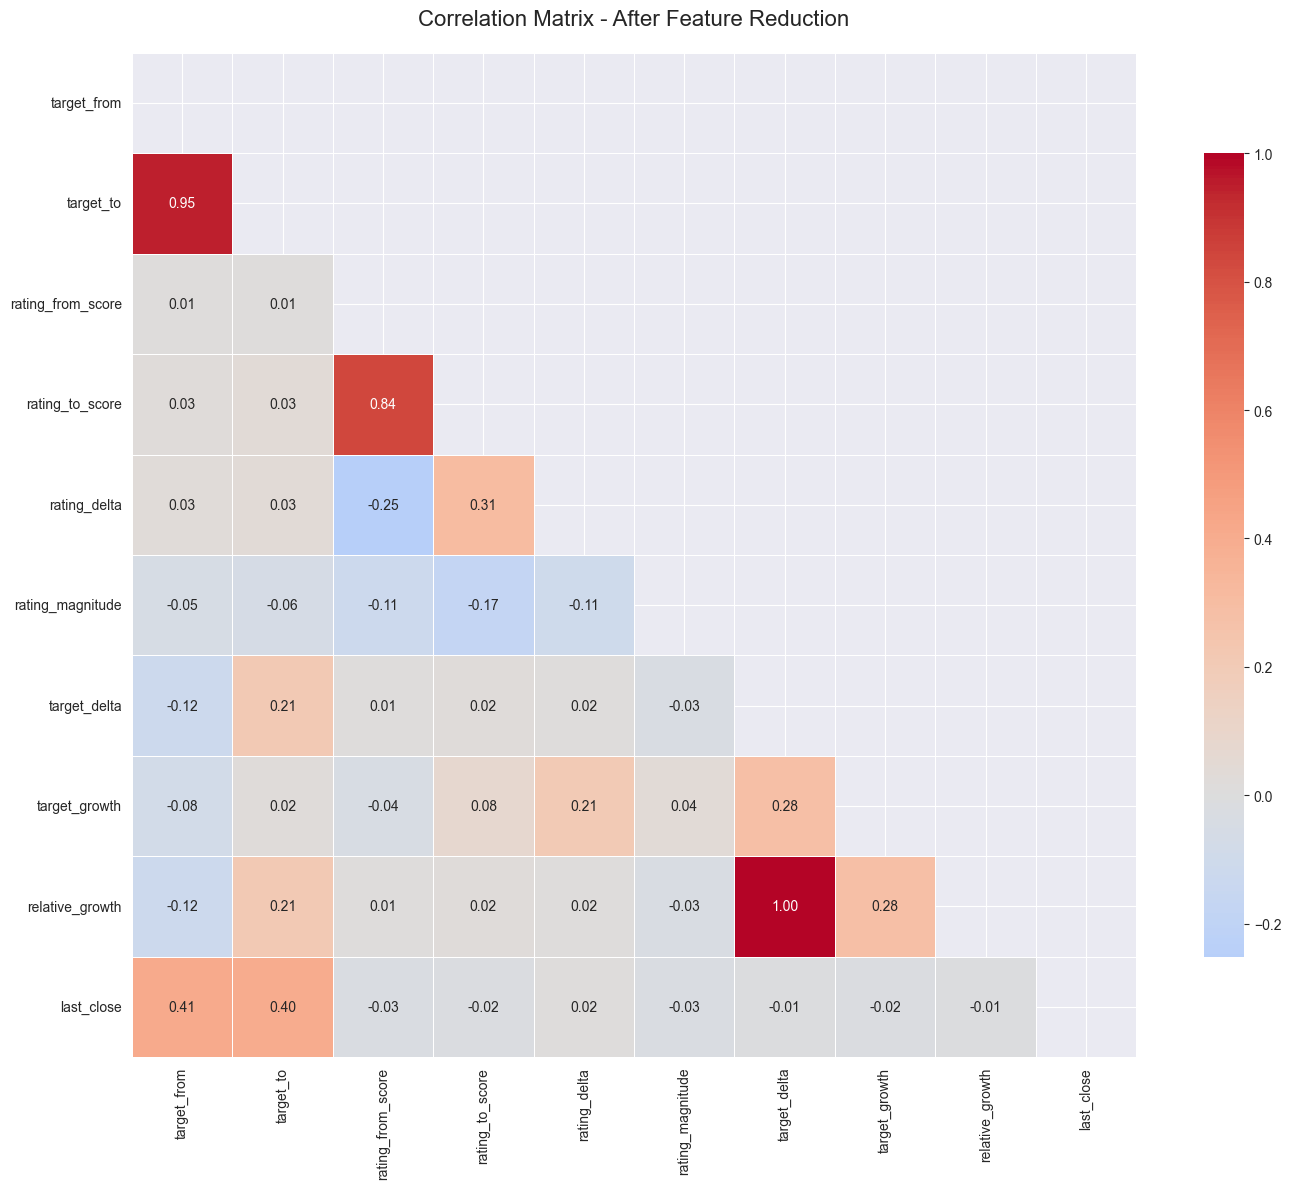

Correlation matrix shape after reduction: (10, 10)
Features in reduced correlation matrix: 10


In [33]:
reduced_correlation_matrix = df_clean[numerical_columns].corr()

plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(reduced_correlation_matrix, dtype=bool))
sns.heatmap(reduced_correlation_matrix, mask=mask, annot=True, cmap="coolwarm", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt=".2f")
plt.title("Correlation Matrix - After Feature Reduction", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print(f"Correlation matrix shape after reduction: {reduced_correlation_matrix.shape}")
print(f"Features in reduced correlation matrix: {len(numerical_columns)}")

## 4. Independent Features Selection

### Process Description
Final feature selection process that combines original analyst features with the most informative technical indicators, creating a comprehensive yet non-redundant feature set for clustering analysis.

### Key Activities
- **Feature Combination**: Merge original analyst features with selected technical indicators
- **Correlation Validation**: Ensure selected features have low inter-correlation
- **Feature Documentation**: Categorize and explain the final feature set
- **Dataset Export**: Save independent features for clustering analysis

### Conclusion
Independent features selection successfully created a comprehensive 10-feature dataset combining analyst insights with market dynamics. The final feature set includes 9 original analyst features plus 1 technical indicator (last_close), providing a balanced representation of both fundamental analysis and market behavior. This dataset is optimized for clustering analysis with minimal redundancy and maximum information content.

### Final Feature Set
The independent features combine original engineered features with reduced technical indicators to create a comprehensive yet non-redundant feature set for clustering analysis.

In [34]:
print(numerical_columns)

['target_from', 'target_to', 'rating_from_score', 'rating_to_score', 'rating_delta', 'rating_magnitude', 'target_delta', 'target_growth', 'relative_growth', 'last_close']


In [35]:
# Save independent features dataset
df_independent= df_clean[numerical_columns]
df_independent['ticker'] = tikers_column
df_independent.to_csv("stock_data_independent_features2.csv", index=False)

print("=== DATASET SAVED ===")
print(f"Independent features dataset saved as: stock_data_independent_features2.csv")
print(f"Final shape: {df_independent.shape}")
print(f"Features: {len(numerical_columns)}")
print(f"Rows: {df_independent.shape[0]}")
print(f"Data quality: Clean (no nulls, no infinite values)")
print(f"Ready for clustering analysis!")

=== DATASET SAVED ===
Independent features dataset saved as: stock_data_independent_features2.csv
Final shape: (2739, 11)
Features: 10
Rows: 2739
Data quality: Clean (no nulls, no infinite values)
Ready for clustering analysis!
